In [114]:
from math import log, exp
import itertools
import math
import random
import scipy

class GSOM_Node:
    R = random.Random()
    
    def __init__(self, dim, x, y):
        # Create a weight vector of the given dimension:
        # Initialize the weight vector with random values between 0 and 1.
        self.weights=scipy.array([self.R.random() for _ in range(dim)])

        self.error = 0.0

        self.it = 0
        self.last_it = 0

        self.data = None
        self.last_changed = 0

        self.right = None
        self.left  = None
        self.up    = None
        self.down  = None

        self.x, self.y = x, y


    def adjust_weights(self, target, learn_rate):
        """ Adjust the weights of this node. """
        for w in range(0, len(target)):
            self.weights[w] += learn_rate * (target[w] - self.weights[w])


    def is_boundary(self):
        """ Check if this node is at the boundary of the map. """
        if not self.right: return True
        if not self.left:  return True
        if not self.up:    return True
        if not self.down:  return True
        return False



In [116]:
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import iris data
iris = datasets.load_iris()
dataset = iris
spread_factor = 0.5
# Assign the data
data = []
for fn in dataset:
    t = dataset
    arr = scipy.array(t.data)
    data.append([fn,arr])

# Determine the dimension of the data.
dim = len(data[0][1])

# Calculate the growing threshold:
_GT = -dim * math.log(spread_factor, 2)

# Create the 4 starting Nodes.
nodes = []
n00 = GSOM_Node(dim, 0, 0)
n01 = GSOM_Node(dim, 0, 1)
n10 = GSOM_Node(dim, 1, 0)
n11 = GSOM_Node(dim, 1, 1)
nodes.extend([n00,n01,n10,n11])

# Create starting topology
n00.right = n10
n00.up    = n01
n01.right = n11
n01.down  = n00
n10.up    = n11
n10.left  = n00
n11.left  = n01
n11.down  = n10

# Set properties
it = 0       # Current iteration
max_it = len(data)
num_it = 100     # Total iterations
init_lr = 0.1     # Initial value of the learning rate
alpha = 0.1
output = file = open("gsom.csv","w")

print(len(n00.weights))

150


In [117]:
def _distance(v1, v2):
    dist = 0.0
    #print(v1)
    #print(v2)
    for v, w in zip(v1, v2):
        dist += pow(v - w,2)
    return dist


def _find_bmu(vec):
    dist=float("inf")
    winner = False
    for node in nodes:
        d = _distance(vec, node.weights)
        #print(d.all())            
        if(d < dist):
            dist = d
            winner = node

    return winner


def _find_similar_boundary(node):
    dist = float("inf")
    winner = False
    for boundary in nodes:
        if not boundary.is_boundary(): continue
        if boundary == node: continue

        d = _distance(node.weights, boundary.weights)
        if d < dist:
            dist = d
            winner = node

    return winner

In [118]:
def _node_add_error(node, error):

    node.error += error

    # Consider growing
    if node.error > _GT:
        if not node.is_boundary():
            node = _find_similar_boundary(node)
            if not node:
                print("GSOM: Error: No free boundary node found!")

        nodes = _grow(node)
        return True, nodes

    return False, 0


def _grow(node):
    """ Grow this GSOM. """
    # We grow this GSOM in every possible direction.
    nodes = []
    if node.left == None:
        nn = _insert(node.x - 1, node.y, node)
        nodes.append(nn)
        print("Growing left at: (" + str(node.x) + "," + str(node.y)\
                + ") -> (" + str(nn.x) + ", " + str(nn.y) + ")")

    if node.right == None:
        nn = _insert(node.x + 1, node.y, node)
        nodes.append(nn)
        print("Growing right at: (" + str(node.x) + "," + str(node.y)\
                + ") -> (" + str(nn.x) + ", " + str(nn.y) + ")")

    if node.up == None:
        nn = _insert(node.x, node.y + 1, node)
        nodes.append(nn)
        print("Growing up at: (" + str(node.x) + "," + str(node.y) +\
                ") -> (" + str(nn.x) + ", " + str(nn.y) + ")")

    if node.down == None:
        nn = _insert(node.x, node.y - 1, node)
        nodes.append(nn)
        print("Growing down at: (" + str(node.x) + "," + str(node.y) +\
                ") -> (" + str(nn.x) + ", " + str(nn.y) + ")")
    return nodes


def _insert(x, y, init_node):
    # Create new node
    new_node = GSOM_Node(dim, x, y)
    nodes.append(new_node)

    new_node.it = new_node.last_it = it

    # Create the connections to possible neighbouring nodes.
    for node in nodes:
        # Left, Right, Up, Down
        if node.x == x - 1 and node.y == y:
            new_node.left = node
            node.right = new_node
        if node.x == x + 1 and node.y == y:
            new_node.right = node
            node.left = new_node
        if node.x == x and node.y == y + 1:
            new_node.up = node
            node.down = new_node
        if node.x == x and node.y == y - 1:
            new_node.down = node
            node.up = new_node

    # Calculate new weights, look for a neighbour.
    neigh = new_node.left
    if neigh == None: neigh = new_node.right
    if neigh == None: neigh = new_node.up
    if neigh == None: neigh = new_node.down
    if neigh == None: print("_insert: No neighbour found!")

    for i in range(0, len(new_node.weights)):
        new_node.weights[i] = 2 * init_node.weights[i] - neigh.weights[i]

    return new_node


def _remove_unused_nodes():
    """ Remove all nodes from the GSOM that have not been used. """
    to_remove = []

    # Iterate over all nodes.
    for node in nodes:
        iterations_not_won = it - node.last_it
        if iterations_not_won < len(nodes) * 4.0 * (1 + it/len(data)) : continue

        if node.left:  node.left.right = None
        if node.up:    node.up.down    = None
        if node.down:  node.down.up    = None
        if node.right: node.right.left = None

        to_remove.append(node)

    # Now remove all marked nodes.
    for node in to_remove:
        print("Removing node @ " + str(node.x) + ", " + str(node.y) + \
              " - Current it: " + str(it) + " - Last time won: " +\
              str(node.last_it))
        if node.data:
            output.write(node.data + "," + str(node.x)+","+str(node.y)\
                + ",remove\n")
    nodes.remove(node)

In [119]:
## training & viz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


In [124]:
input = random.choice(data)[1]
learn_rate = init_lr * alpha * (1 - 1.5/len(nodes))

recalc_nodes = []
for _ in range(1000):
    # best matching unit
    l0 = [i[0] for i in input]
    #print(l0)
    BMU = _find_bmu(l0)
    BMU.last_it = it

    # Adapt the weights of the direct topological neighbours
    neighbours = []
    neighbours.append(BMU)
    if BMU.left:  neighbours.append(BMU.left)
    if BMU.right: neighbours.append(BMU.right)
    if BMU.up:    neighbours.append(BMU.up)
    if BMU.down:  neighbours.append(BMU.down)

    if BMU not in recalc_nodes: recalc_nodes.append(BMU)

    for node in neighbours:
        node.adjust_weights(l0, learn_rate)
        if node not in recalc_nodes: recalc_nodes.append(node)

    # Calculate the error.
    err = _distance(BMU.weights, l0)

    # Add the error to the node.
    growing, nodes = _node_add_error(BMU, err)
    if growing: recalc_nodes.extend(nodes)

    # Count the iteration
    it += 1

    # Re-Calc representative data elements for changed nodes.
    used_data = []
    for node in nodes:
        used_data.append(node.data)

    for node in recalc_nodes:
        dist = float("inf")
        winner = False
        winner_fn = False
    
        for fn,point in data:
            if fn in used_data: continue

            point0 = [i[0] for i in point]
            d = _distance(point0, node.weights)
            if(d < dist):
                dist = d
                winner = point0
                winner_fn = fn

        if node.data != winner_fn:
            node.data = winner_fn
            node.last_changed = it
        output.write(str(node.data) + "," + str(node.x) + "," + str(node.y)\
                + ",change\n")
        used_data.append(winner_fn)

    # Remove unused nodes.
    _remove_unused_nodes()

    


Growing right at: (651,50) -> (652, 50)
Growing up at: (651,50) -> (651, 51)
Growing down at: (651,50) -> (651, 49)
Growing right at: (651,51) -> (652, 51)
Growing up at: (651,51) -> (651, 52)
Growing right at: (652,51) -> (653, 51)
Growing up at: (652,51) -> (652, 52)
Growing right at: (653,51) -> (654, 51)
Growing up at: (653,51) -> (653, 52)
Growing down at: (653,51) -> (653, 50)
Growing right at: (654,51) -> (655, 51)
Growing up at: (654,51) -> (654, 52)
Growing down at: (654,51) -> (654, 50)
Growing right at: (654,52) -> (655, 52)
Growing up at: (654,52) -> (654, 53)
Growing right at: (655,52) -> (656, 52)
Growing up at: (655,52) -> (655, 53)
Growing right at: (656,52) -> (657, 52)
Growing up at: (656,52) -> (656, 53)
Growing down at: (656,52) -> (656, 51)
Growing right at: (657,52) -> (658, 52)
Growing up at: (657,52) -> (657, 53)
Growing down at: (657,52) -> (657, 51)
Growing right at: (657,53) -> (658, 53)
Growing up at: (657,53) -> (657, 54)
Growing right at: (658,53) -> (659,

Growing right at: (729,77) -> (730, 77)
Growing up at: (729,77) -> (729, 78)
Growing right at: (730,77) -> (731, 77)
Growing up at: (730,77) -> (730, 78)
Growing right at: (731,77) -> (732, 77)
Growing up at: (731,77) -> (731, 78)
Growing down at: (731,77) -> (731, 76)
Growing right at: (732,77) -> (733, 77)
Growing up at: (732,77) -> (732, 78)
Growing down at: (732,77) -> (732, 76)
Growing right at: (732,78) -> (733, 78)
Growing up at: (732,78) -> (732, 79)
Growing right at: (733,78) -> (734, 78)
Growing up at: (733,78) -> (733, 79)
Growing right at: (734,78) -> (735, 78)
Growing up at: (734,78) -> (734, 79)
Growing down at: (734,78) -> (734, 77)
Growing right at: (735,78) -> (736, 78)
Growing up at: (735,78) -> (735, 79)
Growing down at: (735,78) -> (735, 77)
Growing right at: (735,79) -> (736, 79)
Growing up at: (735,79) -> (735, 80)
Growing right at: (736,79) -> (737, 79)
Growing up at: (736,79) -> (736, 80)
Growing right at: (737,79) -> (738, 79)
Growing up at: (737,79) -> (737, 8

Growing right at: (794,98) -> (795, 98)
Growing up at: (794,98) -> (794, 99)
Growing down at: (794,98) -> (794, 97)
Growing right at: (795,98) -> (796, 98)
Growing up at: (795,98) -> (795, 99)
Growing down at: (795,98) -> (795, 97)
Growing right at: (795,99) -> (796, 99)
Growing up at: (795,99) -> (795, 100)
Growing right at: (796,99) -> (797, 99)
Growing up at: (796,99) -> (796, 100)
Growing right at: (797,99) -> (798, 99)
Growing up at: (797,99) -> (797, 100)
Growing down at: (797,99) -> (797, 98)
Growing right at: (798,99) -> (799, 99)
Growing up at: (798,99) -> (798, 100)
Growing down at: (798,99) -> (798, 98)
Growing right at: (798,100) -> (799, 100)
Growing up at: (798,100) -> (798, 101)
Growing right at: (799,100) -> (800, 100)
Growing up at: (799,100) -> (799, 101)
Growing right at: (800,100) -> (801, 100)
Growing up at: (800,100) -> (800, 101)
Growing down at: (800,100) -> (800, 99)
Growing right at: (801,100) -> (802, 100)
Growing up at: (801,100) -> (801, 101)
Growing down a

Growing up at: (860,120) -> (860, 121)
Growing down at: (860,120) -> (860, 119)
Growing right at: (861,120) -> (862, 120)
Growing up at: (861,120) -> (861, 121)
Growing down at: (861,120) -> (861, 119)
Growing right at: (861,121) -> (862, 121)
Growing up at: (861,121) -> (861, 122)
Growing right at: (862,121) -> (863, 121)
Growing up at: (862,121) -> (862, 122)
Growing right at: (863,121) -> (864, 121)
Growing up at: (863,121) -> (863, 122)
Growing down at: (863,121) -> (863, 120)
Growing right at: (864,121) -> (865, 121)
Growing up at: (864,121) -> (864, 122)
Growing down at: (864,121) -> (864, 120)
Growing right at: (864,122) -> (865, 122)
Growing up at: (864,122) -> (864, 123)
Growing right at: (865,122) -> (866, 122)
Growing up at: (865,122) -> (865, 123)
Growing right at: (866,122) -> (867, 122)
Growing up at: (866,122) -> (866, 123)
Growing down at: (866,122) -> (866, 121)
Growing right at: (867,122) -> (868, 122)
Growing up at: (867,122) -> (867, 123)
Growing down at: (867,122) 

Growing right at: (928,143) -> (929, 143)
Growing up at: (928,143) -> (928, 144)
Growing right at: (929,143) -> (930, 143)
Growing up at: (929,143) -> (929, 144)
Growing down at: (929,143) -> (929, 142)
Growing right at: (930,143) -> (931, 143)
Growing up at: (930,143) -> (930, 144)
Growing down at: (930,143) -> (930, 142)
Growing right at: (930,144) -> (931, 144)
Growing up at: (930,144) -> (930, 145)
Growing right at: (931,144) -> (932, 144)
Growing up at: (931,144) -> (931, 145)
Growing right at: (932,144) -> (933, 144)
Growing up at: (932,144) -> (932, 145)
Growing down at: (932,144) -> (932, 143)
Growing right at: (933,144) -> (934, 144)
Growing up at: (933,144) -> (933, 145)
Growing down at: (933,144) -> (933, 143)
Growing right at: (933,145) -> (934, 145)
Growing up at: (933,145) -> (933, 146)
Growing right at: (934,145) -> (935, 145)
Growing up at: (934,145) -> (934, 146)
Growing right at: (935,145) -> (936, 145)
Growing up at: (935,145) -> (935, 146)
Growing down at: (935,145)

Growing right at: (995,165) -> (996, 165)
Growing up at: (995,165) -> (995, 166)
Growing down at: (995,165) -> (995, 164)
Growing right at: (996,165) -> (997, 165)
Growing up at: (996,165) -> (996, 166)
Growing down at: (996,165) -> (996, 164)
Growing right at: (996,166) -> (997, 166)
Growing up at: (996,166) -> (996, 167)
Growing right at: (997,166) -> (998, 166)
Growing up at: (997,166) -> (997, 167)
Growing right at: (998,166) -> (999, 166)
Growing up at: (998,166) -> (998, 167)
Growing down at: (998,166) -> (998, 165)
Growing right at: (999,166) -> (1000, 166)
Growing up at: (999,166) -> (999, 167)
Growing down at: (999,166) -> (999, 165)
Growing right at: (999,167) -> (1000, 167)
Growing up at: (999,167) -> (999, 168)
Growing right at: (1000,167) -> (1001, 167)
Growing up at: (1000,167) -> (1000, 168)
Growing right at: (1001,167) -> (1002, 167)
Growing up at: (1001,167) -> (1001, 168)
Growing down at: (1001,167) -> (1001, 166)
Growing right at: (1002,167) -> (1003, 167)
Growing up

Growing right at: (1059,187) -> (1060, 187)
Growing up at: (1059,187) -> (1059, 188)
Growing right at: (1060,187) -> (1061, 187)
Growing up at: (1060,187) -> (1060, 188)
Growing right at: (1061,187) -> (1062, 187)
Growing up at: (1061,187) -> (1061, 188)
Growing down at: (1061,187) -> (1061, 186)
Growing right at: (1062,187) -> (1063, 187)
Growing up at: (1062,187) -> (1062, 188)
Growing down at: (1062,187) -> (1062, 186)
Growing right at: (1062,188) -> (1063, 188)
Growing up at: (1062,188) -> (1062, 189)
Growing right at: (1063,188) -> (1064, 188)
Growing up at: (1063,188) -> (1063, 189)
Growing right at: (1064,188) -> (1065, 188)
Growing up at: (1064,188) -> (1064, 189)
Growing down at: (1064,188) -> (1064, 187)
Growing right at: (1065,188) -> (1066, 188)
Growing up at: (1065,188) -> (1065, 189)
Growing down at: (1065,188) -> (1065, 187)
Growing right at: (1065,189) -> (1066, 189)
Growing up at: (1065,189) -> (1065, 190)
Growing right at: (1066,189) -> (1067, 189)
Growing up at: (106

Growing right at: (1118,206) -> (1119, 206)
Growing up at: (1118,206) -> (1118, 207)
Growing down at: (1118,206) -> (1118, 205)
Growing right at: (1119,206) -> (1120, 206)
Growing up at: (1119,206) -> (1119, 207)
Growing down at: (1119,206) -> (1119, 205)
Growing right at: (1119,207) -> (1120, 207)
Growing up at: (1119,207) -> (1119, 208)
Growing right at: (1120,207) -> (1121, 207)
Growing up at: (1120,207) -> (1120, 208)
Growing right at: (1121,207) -> (1122, 207)
Growing up at: (1121,207) -> (1121, 208)
Growing down at: (1121,207) -> (1121, 206)
Growing right at: (1122,207) -> (1123, 207)
Growing up at: (1122,207) -> (1122, 208)
Growing down at: (1122,207) -> (1122, 206)
Growing right at: (1122,208) -> (1123, 208)
Growing up at: (1122,208) -> (1122, 209)
Growing right at: (1123,208) -> (1124, 208)
Growing up at: (1123,208) -> (1123, 209)
Growing right at: (1124,208) -> (1125, 208)
Growing up at: (1124,208) -> (1124, 209)
Growing down at: (1124,208) -> (1124, 207)
Growing right at: (1

Growing right at: (1176,226) -> (1177, 226)
Growing up at: (1176,226) -> (1176, 227)
Growing right at: (1177,226) -> (1178, 226)
Growing up at: (1177,226) -> (1177, 227)
Growing right at: (1178,226) -> (1179, 226)
Growing up at: (1178,226) -> (1178, 227)
Growing down at: (1178,226) -> (1178, 225)
Growing right at: (1179,226) -> (1180, 226)
Growing up at: (1179,226) -> (1179, 227)
Growing down at: (1179,226) -> (1179, 225)
Growing right at: (1179,227) -> (1180, 227)
Growing up at: (1179,227) -> (1179, 228)
Growing right at: (1180,227) -> (1181, 227)
Growing up at: (1180,227) -> (1180, 228)
Growing right at: (1181,227) -> (1182, 227)
Growing up at: (1181,227) -> (1181, 228)
Growing down at: (1181,227) -> (1181, 226)
Growing right at: (1182,227) -> (1183, 227)
Growing up at: (1182,227) -> (1182, 228)
Growing down at: (1182,227) -> (1182, 226)
Growing right at: (1182,228) -> (1183, 228)
Growing up at: (1182,228) -> (1182, 229)
Growing right at: (1183,228) -> (1184, 228)
Growing up at: (118

Growing right at: (1238,246) -> (1239, 246)
Growing up at: (1238,246) -> (1238, 247)
Growing down at: (1238,246) -> (1238, 245)
Growing right at: (1239,246) -> (1240, 246)
Growing up at: (1239,246) -> (1239, 247)
Growing down at: (1239,246) -> (1239, 245)
Growing right at: (1239,247) -> (1240, 247)
Growing up at: (1239,247) -> (1239, 248)
Growing right at: (1240,247) -> (1241, 247)
Growing up at: (1240,247) -> (1240, 248)
Growing right at: (1241,247) -> (1242, 247)
Growing up at: (1241,247) -> (1241, 248)
Growing down at: (1241,247) -> (1241, 246)
Growing right at: (1242,247) -> (1243, 247)
Growing up at: (1242,247) -> (1242, 248)
Growing down at: (1242,247) -> (1242, 246)
Growing right at: (1242,248) -> (1243, 248)
Growing up at: (1242,248) -> (1242, 249)
Growing right at: (1243,248) -> (1244, 248)
Growing up at: (1243,248) -> (1243, 249)
Growing right at: (1244,248) -> (1245, 248)
Growing up at: (1244,248) -> (1244, 249)
Growing down at: (1244,248) -> (1244, 247)
Growing right at: (1

TypeError: 'int' object is not iterable

In [137]:
import pandas as pd
df = pd.read_csv('gsom.csv')
df.shape
x = df['1']
y = df['0']

Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/matplotlib/animation.py", line 1081, in _start
    self._init_draw()
  File "/usr/local/lib/python2.7/dist-packages/matplotlib/animation.py", line 1792, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/usr/local/lib/python2.7/dist-packages/matplotlib/animation.py", line 1814, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
TypeError: 'Line2D' object is not callable


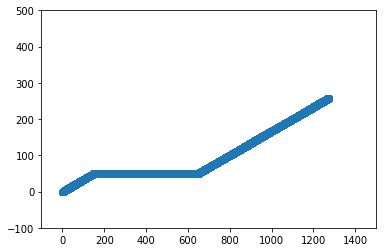

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


fig = plt.figure()
plt.ylim(-100, 500)
plt.xlim(-100, 1500)
graph, = plt.plot([], [], 'o')

def animate(i):
    graph.set_data(x[:i+1], y[:i+1])
    return graph

ani = FuncAnimation(fig, animate(2000000000000), frames=10, interval=200)
plt.show()

In [140]:
# viz needs more iterations for better understanding, will add more. 
# currently causing bugs after a limit

In [144]:
## understanding output file


In [145]:
df.describe() # basic description of variables present

# 1 and 0 represent the x and y coordinates of the winner node

,1,0
count,1.298399e+06,1.298398e+06
mean,6.697577e+02,9.539206e+01
std,3.059955e+02,5.351747e+01
min,0.000000e+00,-1.000000e+00
25%,3.890000e+02,5.100000e+01
50%,7.350000e+02,7.900000e+01
75%,8.940000e+02,1.310000e+02
max,1.275000e+03,2.590000e+02


In [146]:
df.head(10) # first 10 records

,target_names,1,0,change
0,data,0,0.0,change
1,target,1,1.0,change
2,DESCR,2,0.0,change
3,feature_names,1,-1.0,change
4,target_names,1,0.0,change
5,data,0,0.0,change
6,target,1,1.0,change
7,DESCR,2,0.0,change
8,feature_names,1,-1.0,change
9,False,3,0.0,change


In [147]:
df.head(-20)

,target_names,1,0,change
0,data,0,0.0,change
1,target,1,1.0,change
2,DESCR,2,0.0,change
3,feature_names,1,-1.0,change
4,target_names,1,0.0,change
5,data,0,0.0,change
6,target,1,1.0,change
7,DESCR,2,0.0,change
8,feature_names,1,-1.0,change
9,False,3,0.0,change


In [131]:
## debugging

In [132]:
i = 0
for _ in range(20):
    l0 = [i[0] for i in input]
    print(l0)
    BMU = _find_bmu(l0)

[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.6, 5.0, 4.4, 4.9, 5.4, 4.8, 4.8, 4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5.0, 5.0, 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5.0, 5.5, 4.9, 4.4, 5.1, 5.0, 4.5, 4.4, 5.0, 5.1, 4.8, 5.1, 4.6, 5.3, 5.0, 7.0, 6.4, 6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5.0, 5.9, 6.0, 6.1, 5.6, 6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7, 6.0, 5.7, 5.5, 5.5, 5.8, 6.0, 5.4, 6.0, 6.7, 6.3, 5.6, 5.5, 5.5, 6.1, 5.8, 5.0, 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3, 6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5, 7.7, 7.7, 6.0, 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2, 7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6.0, 6.9, 6.7, 6.9, 5.8, 6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9]


TypeError: 'int' object is not iterable

In [146]:
    l0 = [i[0] for i in input]
    print(l0)
    BMU = _find_bmu(l0)
    print(BMU)

[5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.6, 5.0, 4.4, 4.9, 5.4, 4.8, 4.8, 4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5.0, 5.0, 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5.0, 5.5, 4.9, 4.4, 5.1, 5.0, 4.5, 4.4, 5.0, 5.1, 4.8, 5.1, 4.6, 5.3, 5.0, 7.0, 6.4, 6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5.0, 5.9, 6.0, 6.1, 5.6, 6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7, 6.0, 5.7, 5.5, 5.5, 5.8, 6.0, 5.4, 6.0, 6.7, 6.3, 5.6, 5.5, 5.5, 6.1, 5.8, 5.0, 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3, 6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5, 7.7, 7.7, 6.0, 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2, 7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6.0, 6.9, 6.7, 6.9, 5.8, 6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9]
<__main__.GSOM_Node instance at 0x7f9b002b8518>


In [147]:
for fn,point in data:
    if fn in used_data: continue
    print(node.weights)